<font size = 7>DELE ST1504 CA2 Part A: Generative Adversarial Network </font>
<hr>
<font size = 4>
Name: Lee Hong Yi & Yadanar Aung<br>
Admin No: 2223010 & 2214621<br>
Class: DAAA/FT/2B/07<br>
</font>
<hr>

**Objective:**  
Develop a <u>Generative Adversarial Network (GAN) model</u> for <u>image generation</u>, utilizing the <u>CIFAR10 dataset</u>. The model aims to generate <u>1000 high-quality, small color images</u> in <u>10 distinct classes</u>, showcasing its ability to learn and replicate complex visual patterns.

**Background:**  
GANs are a revolutionary class of artificial neural networks used in unsupervised machine learning tasks. They consist of two parts: a Generator, which creates images, and a Discriminator, which evaluates them. The objective is to train a GAN that excels in producing diverse, realistic images that closely mimic the characteristics of the CIFAR10 dataset.

**Key Features:** <br>
<u>Implement and evaluate different GAN architectures</u> to determine the most effective model for the CIFAR10 specific image generation task, which should generate images that not only are visually appealing and realistic but also display a wide range of creativity within the constraints of the 10 classes in the dataset.

**Output Specification:**  
The model will produce images that are evaluated based on their similarity to the real images in the CIFAR10 dataset and their diversity across the dataset's classes. The performance of the GAN will be a crucial indicator of its effectiveness in learning and replicating complex patterns from a given dataset.

<hr>
<font size = 5>Performing initial set-up</font>
<hr>

In [21]:
import gc
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from skimage.transform import resize
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy, Hinge
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Input, Activation, GlobalMaxPooling2D, Conv2DTranspose, PReLU, Embedding, Concatenate
from tensorflow.keras.metrics import Mean
#from tensorflow_addons.layers import SpectralNormalization

import GAN_function as gnnf

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(0)

In [4]:
# Check GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')

# Memory control: Prevent tensorflow from allocating totality of GPU memory
for gpu in gpus:
    try:
        print(tf.config.experimental.get_device_details(gpu))
    except:
        pass
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPU(s) present.")

{'device_name': 'NVIDIA GeForce RTX 3060', 'compute_capability': (8, 6)}
There are 1 GPU(s) present.


<hr>
<font size = 5>Background Research</font>
<hr>

**CIFAR10 Dataset:**  
- The CIFAR10 (Canadian Institute for Advanced Research) dataset consists of <u>60,000 colour images</u> in <u>10 classes</u>.
- There are 6,000 images per class.

**Images:**  
- The images are split into <u>50,000 train images</u> and <u>10,000 test images</u>.
- The images are of <u>size 32x32</u>.

**Classes:**  
- Total of 10 distinct classes:
    1. Airplane
    2. Automoblie
    3. Bird
    4. Cat
    5. Deer
    6. Dog
    7. Frog
    8. Horse
    9. Ship
    10. Truck
- Classes are mutually exclusive.
    - There is no overlap between automobiles and trucks, neither includes pickup trucks.
    - "Automobile" includes sedans, SUVs, etc.
    - "Truck" includes only big trucks.

**Batches:**  
- The dataset is divided into 5 train batches & 1 test batch, each with 10,000 images.
- Train batches contain 50,000 images in total from each class in random order
    - Some batches contain more images from one class than another
- Test batch contains 10,000 randomly-selected images from each class

**Source:**
https://www.cs.toronto.edu/~kriz/cifar.html

<hr>
<font size = 5>Load CIFAR10 Dataset</font>
<hr>
It returns two tuples: (x_train, y_train), (x_test, y_test). The first element of each tuple is an array of images. The second element is an array of corresponding labels.

x_train: uint8 NumPy array of grayscale image data with shapes (50000, 32, 32, 3), containing the training data. Pixel values range from 0 to 255.

y_train: uint8 NumPy array of labels (integers in range 0-9) with shape (50000, 1) for the training data.

x_test: uint8 NumPy array of grayscale image data with shapes (10000, 32, 32, 3), containing the test data. Pixel values range from 0 to 255.

y_test: uint8 NumPy array of labels (integers in range 0-9) with shape (10000, 1) for the test data.

Source: https://keras.io/api/datasets/cifar10/

In [5]:
# Load CIFAR10 Dataset
cifar10 = tf.keras.datasets.cifar10.load_data()

<h3>Split into Train Dataset</h3>

In [6]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10

# Combine Train and Test datasets
# X_train = np.concatenate((X_train, X_test), axis=0)
# y_train = np.concatenate((y_train, y_test), axis=0)

# For EDA Purposes
eda_data = X_train

# Print the shapes of the combined datasets
print(f"Shape of combined X (features): {X_train.shape}")
print(f"Shape of combined y (labels): {y_train.shape}")

Shape of combined X (features): (50000, 32, 32, 3)
Shape of combined y (labels): (50000, 1)


<font size = 5>Define Class Labels</font>

In [7]:
# Map integer class labels to their corresponding class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

<hr>
<font size = 5>Exploratory Data Analysis (EDA)</font>
<hr>

<font size = 5>Image Pixel Distribution</font>

In [8]:
# Obtain Pixel Statistics
min = np.min(eda_data, axis=(0, 1, 2))
max = np.max(eda_data, axis=(0, 1, 2))
mean = np.mean(eda_data, axis=(0, 1, 2))
std = np.std(eda_data, axis=(0, 1, 2))

# Print Statistics
print("\nPixel Statistics for the original train dataset:")
print(f"Minimum pixel value: {min}")
print(f"Maximum pixel value: {max}")
print(f"Mean pixel value: {mean}")
print(f"Standard deviation of pixel values: {std}")


Pixel Statistics for the original train dataset:
Minimum pixel value: [0 0 0]
Maximum pixel value: [255 255 255]
Mean pixel value: [125.30691805 122.95039414 113.86538318]
Standard deviation of pixel values: [62.99321928 62.08870764 66.70489964]


<font size = 5>Class Distribution</font>

In [9]:
classes, counts = np.unique(y_train, return_counts=True)
class_count_dict = dict(zip(class_names, counts))
df = pd.DataFrame({'Count': class_count_dict})
df

,Count
Airplane,5000
Automobile,5000
Bird,5000
Cat,5000
Deer,5000
Dog,5000
Frog,5000
Horse,5000
Ship,5000
Truck,5000


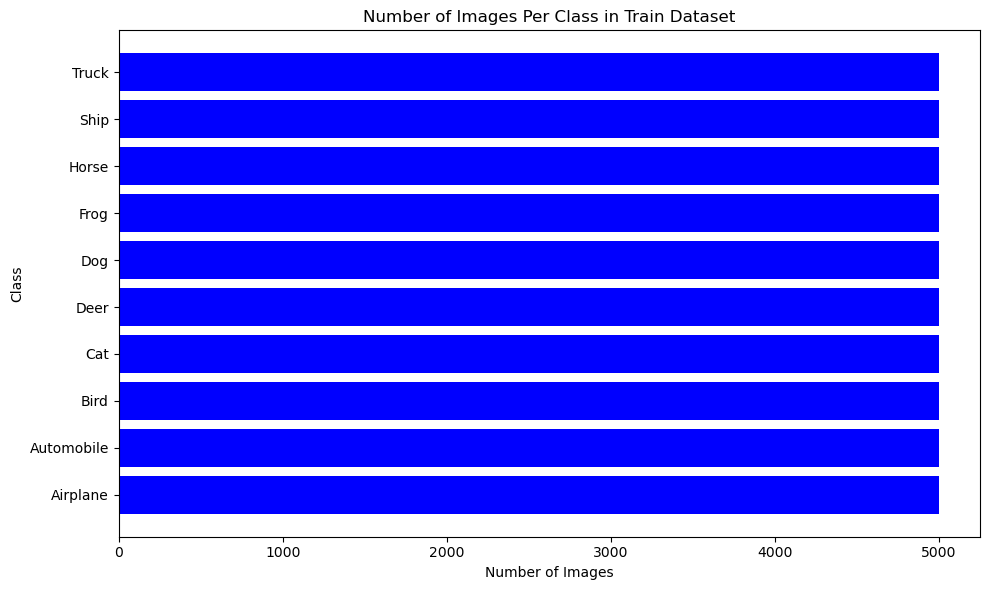

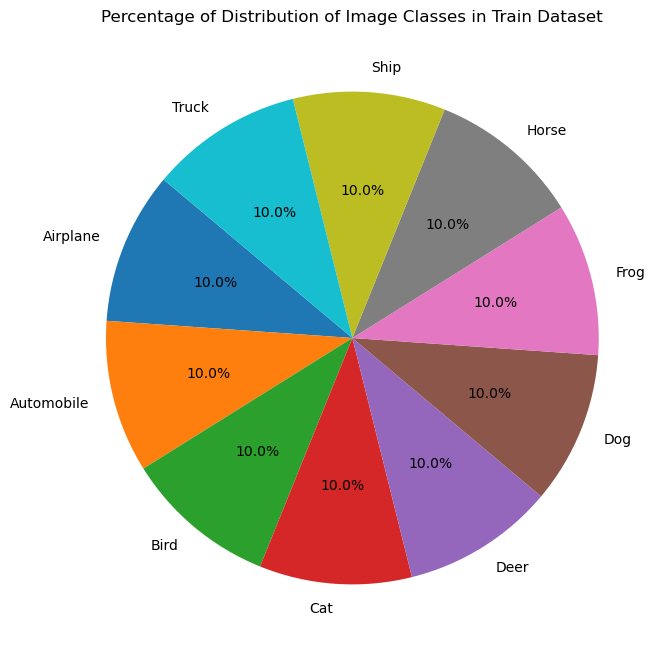

In [10]:
# Visualise Distribution of Image Classes
gnnf.plot_counts(class_count_dict)
gnnf.plot_pie_chart(class_count_dict)

<u>Insights:</u>

- Training dataset is balanced across the different classes.

<font size = 5>Dataset Visualization</font>

Display sample of images from each of the 10 classes.

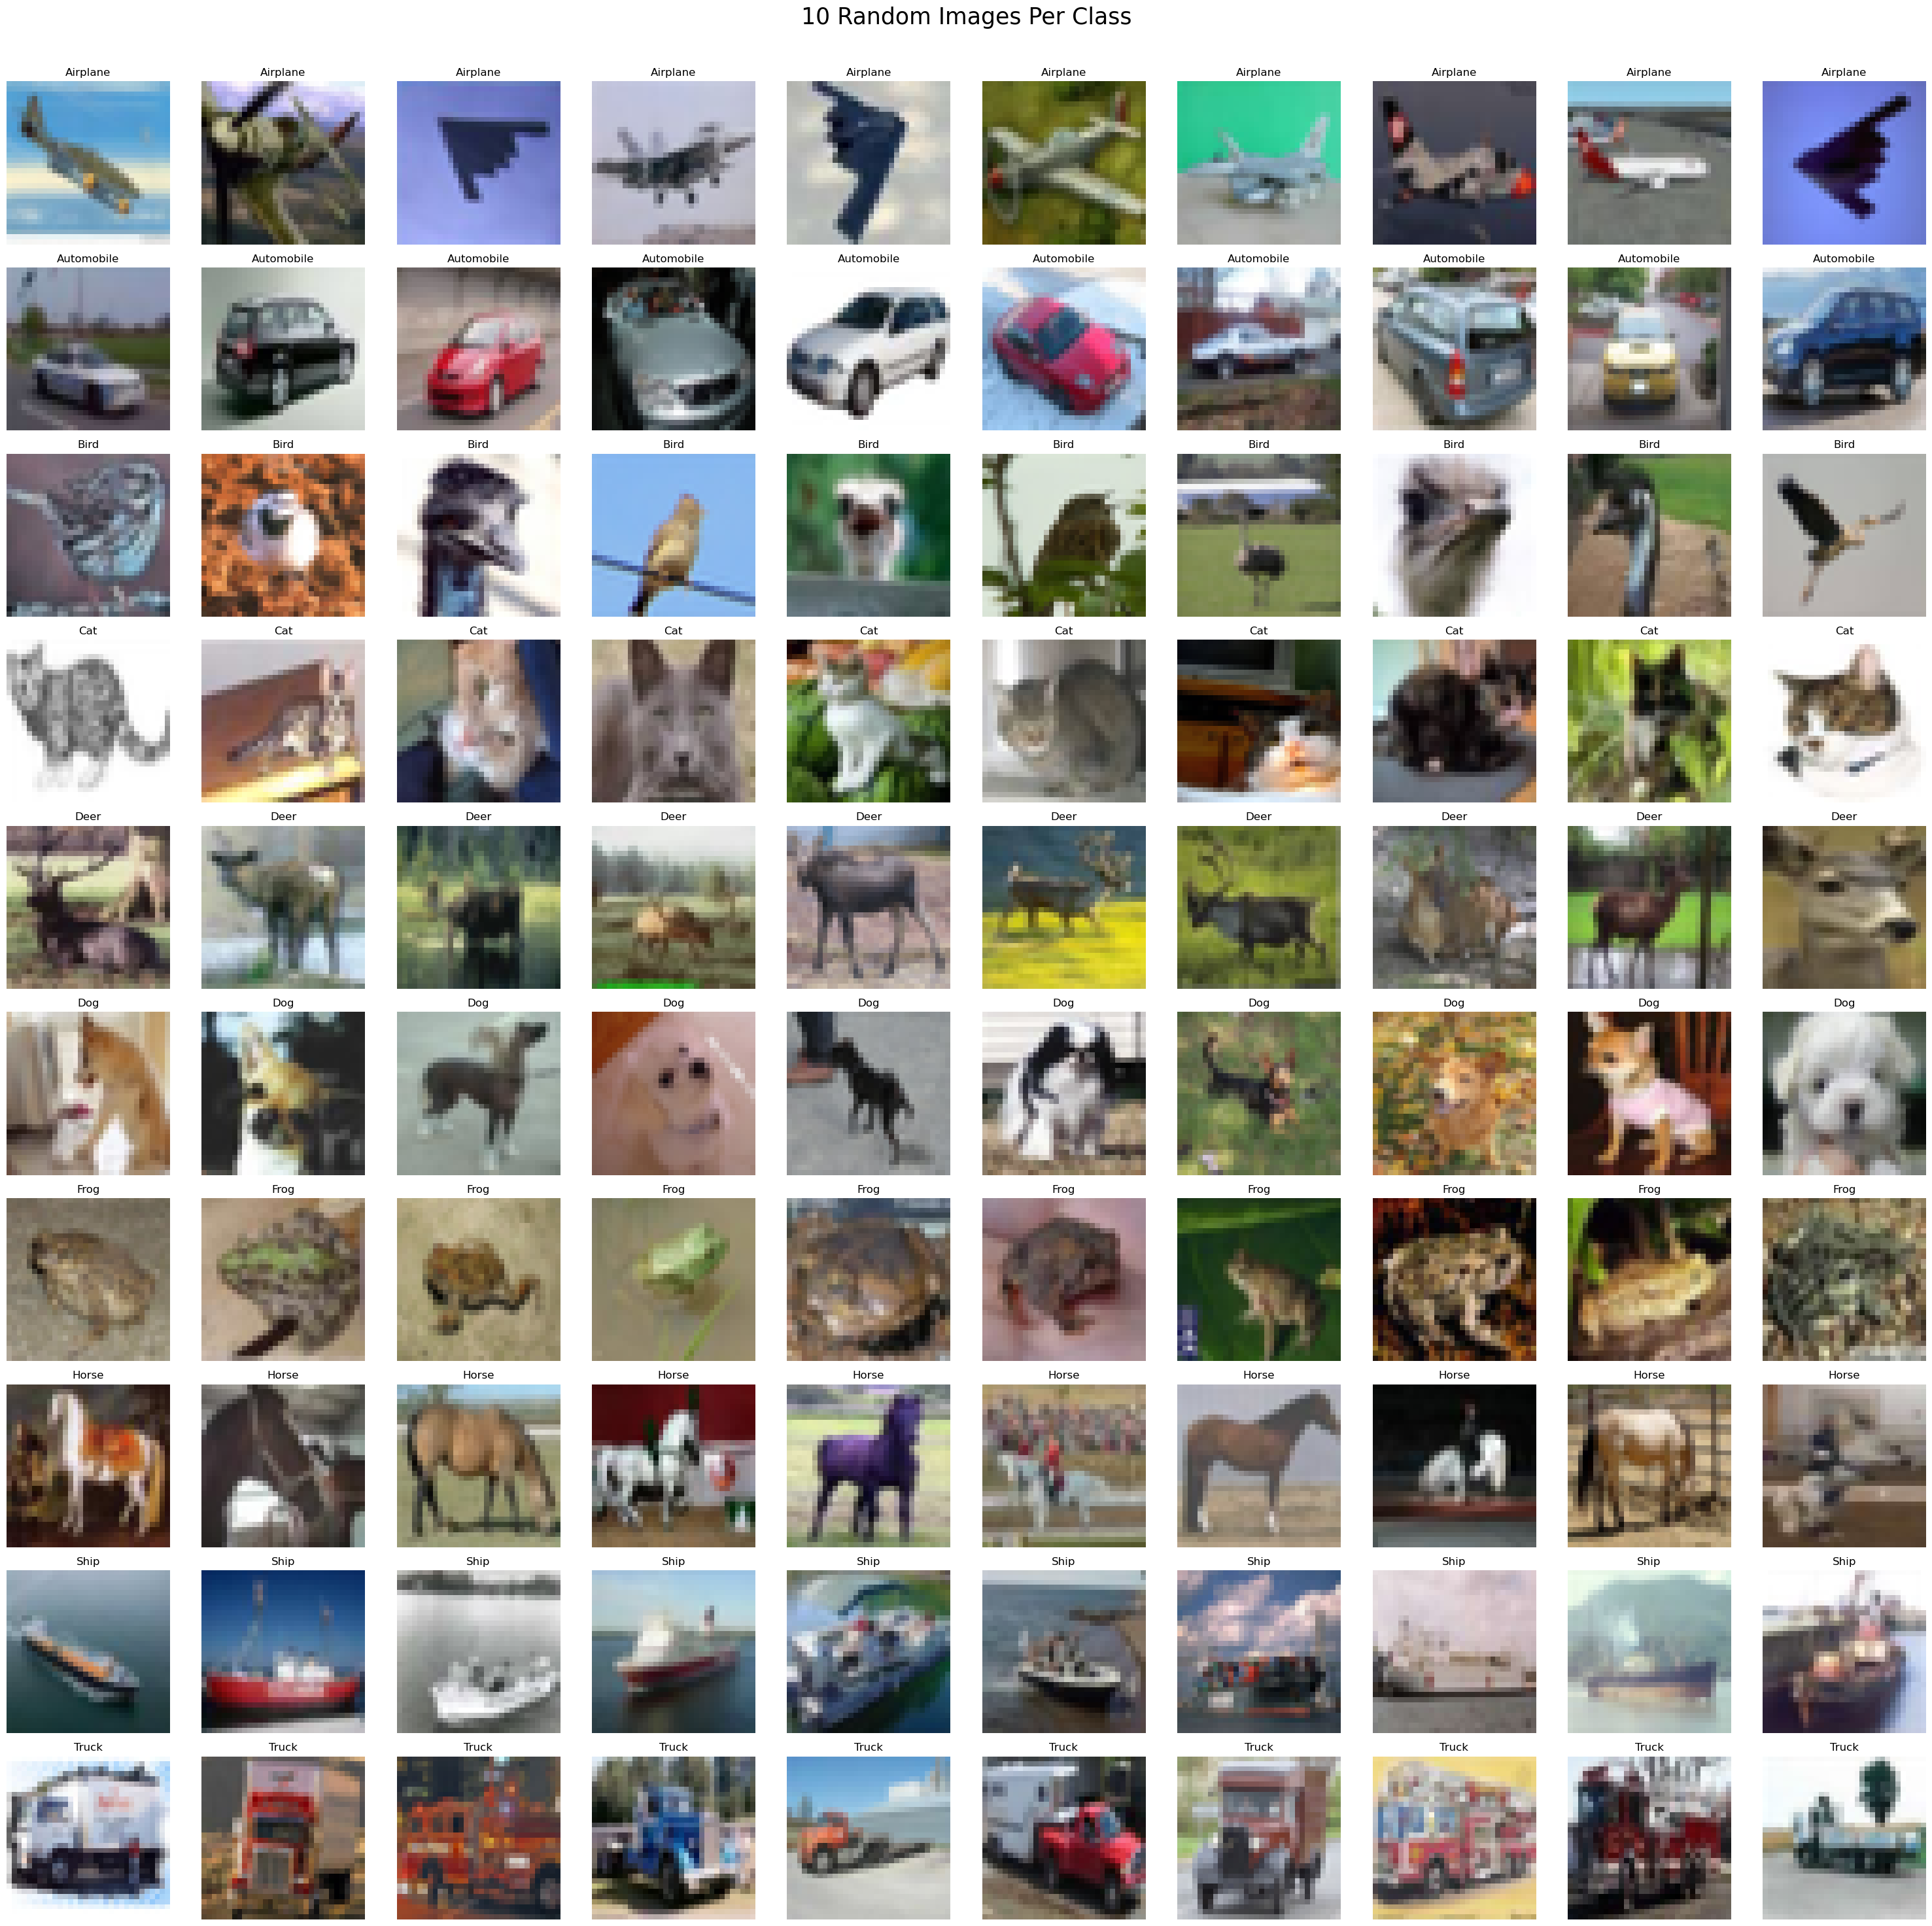

In [11]:
# Create figure & set size
fig, axes = plt.subplots(10, 10, figsize=(30, 30))

for i in range(len(class_names)):
    class_indices = np.where(y_train == i)[0]
    # Randomly select ten images
    random_indices = np.random.choice(class_indices, 10, replace=False)

    for j, image_index in enumerate(random_indices):
        axes[i, j].imshow(eda_data[image_index])
        # Load image
        axes[i, j].axis('off')
        axes[i, j].set_title(class_names[i])

plt.suptitle('10 Random Images Per Class', fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<u>Insights:</u>

- There is a wide variety presented in the images, from the color to the oritentation.
    - Images vary from a close-up shot of the face of the animals to the entire body.
    - Images vary in terms of capturing the front, back, side and top view of the objects.
    - Images within the same classes have different species, for example "Birds" have small and large birds like Ostriches.
- A challenge identified is that there are certain texts in the images, as seen in the "Airplane" and "Cat" images.
    - This might cause the model to unintentionally generate images of texts.
- The quality of the image is rather pixelated, hence certain features of the different classes may overlap.
- The image size is 32x32, hence the impact of the small resolution may make it challenging for the model to learn the distinct features of each classes.

<font size = 5>Image Averaging for Pixel Distribution</font>

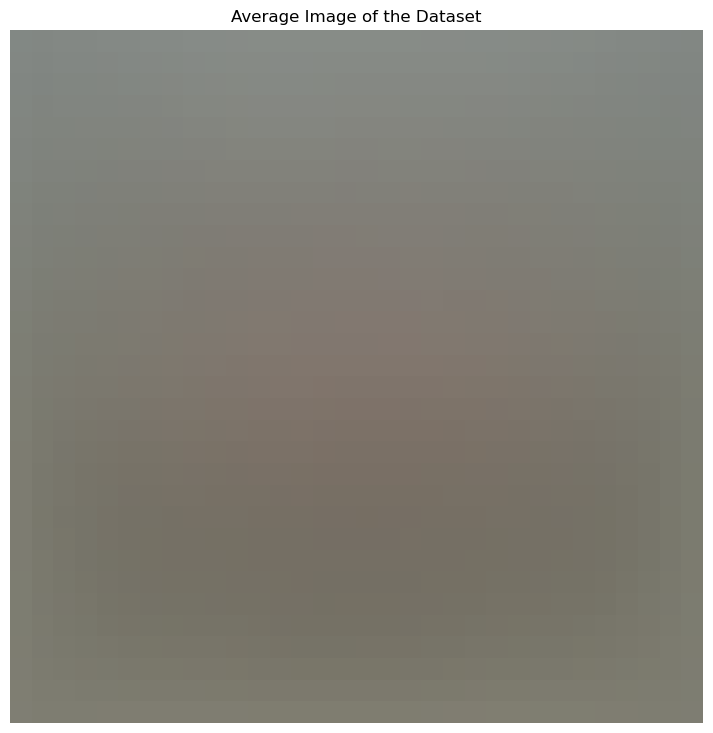

In [12]:
gnnf.average_image(eda_data)

<u>Insights:</u>

- From the above, which is a average of all the pictures in the CIFAR10 dataset, there are no outstanding features across the ten classes
- The dataset also appears to be not uniform, as the image is blurry with no clear indication of a class
- The dataset also seems to be homogenous, with most of the features being shared accross the images
- These may pose challenges later on, as the models may not have enough features to identify the different classes

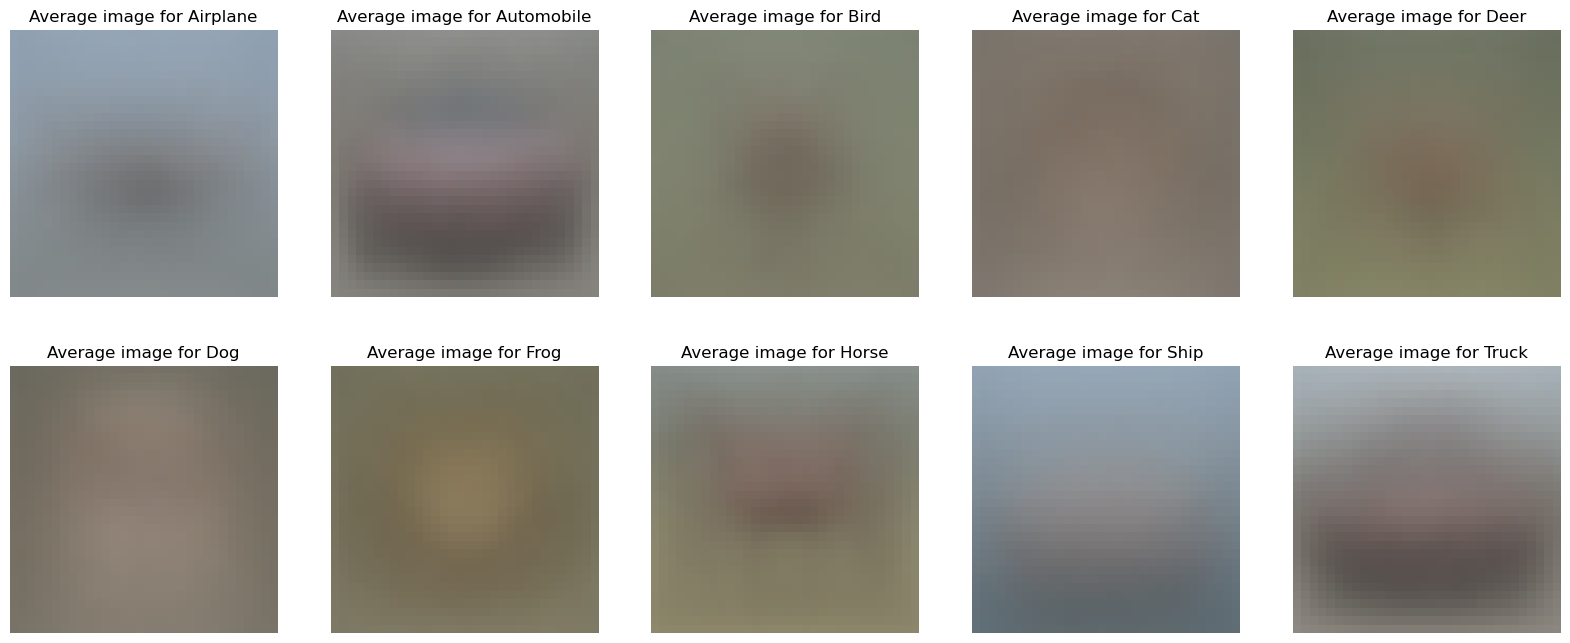

In [13]:
gnnf.average_images_per_class(eda_data, y_train, class_names)

<u>Insights:</u>

- The 4 distinct colors in the dataset are Blue, Green, Brown and Red.
- When the images are averaged, we can still identify the outlines of an Automobile and Horse, implying that the shape of the classes will matter to the models.
- Most of the images have a concentrated color in the center.

<hr>
<font size = 5>Feature Engineering</font>
<hr>

<h3>Normalization </h3>

Currently, the input pixel sizes are in the range [0, 255].

Hence, we are going to <u>rescale the pixel values to the range [-1,1]</u>, so that the model can train more efficiently as pixel inputs with large integer values can slow down the training process.

In [14]:
# Scale from [0,255] to [-1,1]
X_train_rescaled = (X_train / 127.5 - 1.).astype('float32')

# Obtain Pixel Statistics After Rescaling
min = np.min(X_train_rescaled, axis=(0, 1, 2))
max = np.max(X_train_rescaled, axis=(0, 1, 2))
mean = np.mean(X_train_rescaled, axis=(0, 1, 2))
std = np.std(X_train_rescaled, axis=(0, 1, 2))

# Print Statistics
print("Pixel Statistics for the original train dataset:")
print(f"Minimum pixel value: {min}")
print(f"Maximum pixel value: {max}")
print(f"Mean pixel value: {mean}")
print(f"Standard deviation of pixel values: {std}\n")

Pixel Statistics for the original train dataset:
Minimum pixel value: [-1. -1. -1.]
Maximum pixel value: [1. 1. 1.]
Mean pixel value: [-0.01720063 -0.03568322 -0.10693764]
Standard deviation of pixel values: [0.49406543 0.48696858 0.52317506]



<h4>Visualize Before vs After Rescaling</h4>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


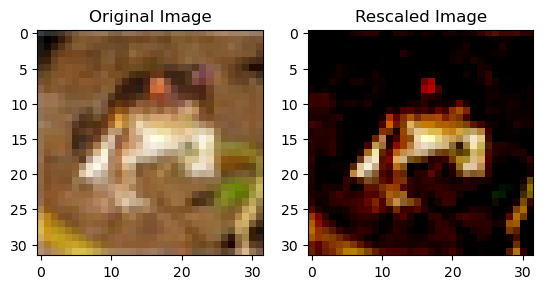

In [15]:
# Plot first image from eda_data
plt.subplot(1, 2, 1)
plt.imshow(eda_data[0])
plt.title('Original Image')

# Plot first image from X_train_dataAug
plt.subplot(1, 2, 2)
plt.imshow(X_train_rescaled[0])
plt.title('Rescaled Image')

plt.show()

<div class='alert alert-block alert-success'><h4>Final Datasets for GAN Model Training</h4></div>

Finally, we are going to convert our finalized datasets to Tensor, from ndarray, for model training.

In [16]:
# Convert frpm ndarray to Tensor
# X_train_rescaled_final = tf.convert_to_tensor((X_train_rescaled))
y_train = tf.convert_to_tensor((y_train))

X_train = tf.data.Dataset.from_tensor_slices((X_train_rescaled, y_train))
X_train = X_train.shuffle(1000).batch(32, drop_remainder=True)

In [17]:
y_test = tf.convert_to_tensor((y_test))


X_test_rescaled = (X_test / 127.5 - 1.).astype('float32')
X_test = tf.data.Dataset.from_tensor_slices((X_test_rescaled, y_test))
X_test = X_test.shuffle(1000).batch(32, drop_remainder=True)

<hr>
<font size = 5>GAN Model Evaluation Methodology</font>
<hr>

As both the Generator and Discriminator are trained together to maintain an equilibirum in a zero-sum game, there is no objective loss function alone to evaluate the performance of the two models.

When measuring the performance of the GAN models, there are two properties to evaluate:
1. <b>Fidelity</b>: Quality of generated images to measure how realistic the images are
2. <b>Diversity</b>: Variety of generated images to measure if it covers the whole variety of the real distribution

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*3nK3IjEbk3vLfYzL'>

A number of qualitative and quantitative techniques has been developed to evaluate the performance of the models, based on the quality and diversity of the generated images.

1. <b>Manual GAN Evaluation</b>
- It involves the manual visual inspection of the images generated by the Generator
- Simplest method
- Limitations include:
    - It is subjective and reviewer may be bias
    - The images from the dataset are of size 32x32, hence leading to difficult in differentiating the classses
    - Reviewing a large amount of generated images is time-consuming

2. <b>Qualitative GAN Evaluation</b>
- It involves human subjective evaluation or evaluation via comparison
- Qualitative Techniques include:
    1. <i><b>Nearest Neighbors</b></i>: Detects overfitting, generated samples are shown next to their nearest neighbors in the training set
    2. <i><b>Rapid Scene Categorization</b></i>: Participants are to distinguish samples from real images in a short view time
    3. <i><b>Rating & Preference Judgement</b></i>: Participants to rank models in terms of the fidelity of their generated images
    4. <i><b>Evaluating Mode Drop & Mode Collapse</b></i>: Over datasets with known modes, modes are computed as by measuring distances of generated data to mode centers
    5. <i><b>Investigating & Visualising the Internals of Networks</b></i>: Explore & illustrate internal representation & dynamics of models, as well as visualizing learned features

3. <b>Quantitative GAN Evaluation</b>
- Refers to calculation of specific numerical scores used to summarize quality of generated images.
- Quantitative Techniques include:
    1. <i><b>Fréchet Inception Distance (FID)</b></i>: Wasserstein-2 distance between multi-variate Guassians fitted to data embedded into a feature space, to evaluate quality of generated images
    2. <i><b>Kullback-Leibler (KL) Divergence</b></i>: Measure of how one probability distribution diverges from a second, expected probability distribution


Sources:<br>
https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/ <br>
https://towardsdatascience.com/on-the-evaluation-of-generative-adversarial-networks-b056ddcdfd3a

<h3><u>Selected Evaluation Metrics</u></h3>

To evaluate our GAN models, we will be using:
1. <i><b>Manual Visual Inspection</b></i>
2. <i><b>FID Score</b></i>
3. <i><b>KL Divergance</b></i>

<h3><b>Fréchet Inception Distance (FID) Score</b></h3>

Fréchet Inception Distance (FID) evaluates the quality of generated images by calculating the distance between feature vectors calculated for real and generated images.

The FID score summarizes the similarity between the real and fake images in terms of statistics on computer vision features of the raw images, calculated by feature extractors. The most common feature extractor is the <u>Inception-v3 classifier</u>, which is pre-trained on ImageNet. By excluding the output layer, we extract the feature maps from the embeddings of the real and fake images. These embeddings are two multivariate normal distributions, which is compared using Wasserstein-2 distance.

<img src='https://www.oreilly.com/api/v2/epubs/9781789136678/files/assets/c23de9d4-5560-4c9f-a0bd-a3569bbf6f5a.png' style="background-color:white" width=1000>

- <i>Where x represents real images, and g represents generated imges.</i>

It is to note that FID has its downsides. It uses a pre-trained Inception model, which may not capture all features, hence introducing biasness depending if the training data differs greatly from the domain of generated images. Moreover, it needs a large dataset to be accurate as it uses limited statistics of only mean and convariance.

Sources:<br>
https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/<br>
https://www.oreilly.com/library/view/generative-adversarial-networks/9781789136678/9bf2e543-8251-409e-a811-77e55d0dc021.xhtml<br>
https://www.techtarget.com/searchenterpriseai/definition/Frechet-inception-distance-FID

In [18]:
def calcFID(input_images, num_images=1000):
    inceptionModel = InceptionV3(
        include_top=False,
        weights="imagenet",
        pooling='avg',
    )

    def scale_images(images, new_shape):
        images_list = []
        for image in images:
            new_image = resize(image, new_shape, anti_aliasing=True)
            images_list.append(new_image)
        return np.array(images_list)

    def calculate_fid(model, images1, images2):
        act1 = model.predict(images1)
        act2 = model.predict(images2)
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
        ssdiff = np.sum((mu1 - mu2)**2.0)
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    (real_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    np.random.shuffle(real_images)

    real_images = real_images[:num_images]
    real_images = real_images.astype('float32')
    # print(real_images)
    real_images = (real_images / 127.5 - 1)
    real_images = scale_images(real_images, (299, 299))

    generated_images = input_images.astype('float32')
    generated_images = scale_images(generated_images, (299, 299))

    fid = calculate_fid(inceptionModel, real_images, generated_images)
    return fid

<hr>
<font size = 5>Initial Modelling</font>
<hr>

<h3><b>Understanding Generative Adversarial Networks (GAN)</b></h3>

GANs are an approach to generative modelling using deep learning methods, like CNNs.

GANs train a generative model by approaching the problem as a supervised learning problem with two sub-models:
1. <b>Generator</b>: Learn to generate plausible new data from random noise
2. <b>Discriminator</b>: Tries to distinguish real data from fake (generated) data, in other words Binary Classification<br>

<img src='https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg' style="background-color:white;" width="500" height="300" >

<h3><b>Training Process</b></h3>

These two models are trained together in a zero-sum game, until the Disciminator is fooled about half the time.

The Generator <u>generates a batch of samples</u>, and along with real samples from the dataset, are provided to the Discriminator to be <u>classified as real (1) or fake (0)</u>.

While one model trains, the other model's weights remain constant, otherwise the Generator would be trying to hit a moving target & might never converge. The training proceeds in <u>alternating periods</u>, where each model take turns training for one or more epochs.

<img src='https://developers.google.com/static/machine-learning/gan/images/gan_diagram_discriminator.svg' style="background-color:white;" width="600" height="300" > <img src='https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg' style="background-color:white;" width="600" height="300" >

<h3><b>Loss Functions</b></h3>

Loss functions reflect the distance between the distribution of generated data and the distribution of real data.

Through backpropagation, the Discriminator's weights are updated from the <u>discriminator loss</u> to get better at discriminating, while the Generator's weights are updated from the <u>generator loss</u> based on the Discriminator classification, which is how well or not the generated samples fool the Discriminator.

Zero-sum game refers to when the Discriminator successfully identifies the real and fake samples, it is <u>rewarded or no change is needed to the model parameters</u>, whereas the <u>the Generator is penalized with large updates to the model parameters</u>, and vice versa.

<h3><b>Convergence</b></h3>

At a limit, the Discriminator cannot tell the difference between perfect replicas and the real images, hence predicts "unsure" (e.g. 50% for real and fake). If the GAN continues training with random feedback from the Discriminator, the model might collapse. For a GAN, convergence is often a fleeting, rather than stable, state.

<h3><b>Wasserstein Loss</b></h3>

This loss function is based on the modification of the GAN scheme (Wasserstein GAN), where the Discriminator does not actually classify the samples.

Instead for each instance it outputs a number. This number does not have to be less than one or greater than 0, so we cannot use 0.5 as a threshold to decide if a sample if real or fake. Discriminator training tried to make the output bigger for real samples.

<u>Critic Loss: D(x) - D(G(z))</u>

The Discriminator tries to maximize this function, which is the difference between its output on real data and fake data.

<u>Generator Loss: D(G(z))</u>

The Generator tries to maximize this function, which is the Discriminator's output for its fake data.

The justification got WGAN requires the weights throughout GAN be clipped to remain within a constrained range.

This avoids problems with vanishing gradients.

Sources: <br>
https://developers.google.com/machine-learning/gan/gan_structure<br>
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/<br>
https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/

<hr>
To start tackling the task, we first design a baseline template class, which we can then build off of to create models which use different architectures. As we have already done our preprocessing, we can go straight onto modelling. 

To start, we shall use the <u>DCGAN architecture as a baseline, then move onto the cGAN, SAGAN, and WGAN architectures</u>. From there, we can pick the best architecture for our task, and hypertune it further to determine our final GAN model to generate images from.

To help us further determine the quality of the model, we shall make use of the <u>Kullback-Leibler Divergence metric (KL Divergence)</u> to help us quantitatively evaluate the results of the model. KL Divergence is a statistical measure that quantifies how different one probability distribution is from another reference probability distribution. It is also known as relative entropy. KL Divergence is non-negative and asymmetric, meaning that the divergence of P from Q is not the same as the divergence of Q from P. It is often used in the field of machine learning to measure the difference between the predicted and true probability distributions of data, or to compare a model's distribution with the empirical distribution of the data.

The formula for KL Divergence is as follows:
\begin{align*}
&D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \left( \frac{P(i)}{Q(i)} \right) \\
&\text{where}\\
&P \text{ is the true distribution} \\
&Q \text{ is the distribution to compare against} \\
&\sum_{i} \text{ is taken over all possible events}
\end{align*}


This equation essentially sums up the product of the probabilities from the true distribution \( P(i) \) and the logarithm of the ratio of probabilities from the true distribution to the comparison distribution \( Q(i) \). It is a measure of the information gained about \( P \) when one uses \( Q \) as the approximation. For our use case, we would want to see a low KL Divergence score, as it means that the distribution of the generated data is very close to the distribution of the real data. This is the goal of a well-functioning GAN – to generate data that is indistinguishable from real data. It also gives us a metric to directly compare models with, and also provides us with feedback on how the model is performing during training.
<hr>

We shall also make use of the <u>Binary Crossentropy loss function</u> to help us here, over other loss functions such as Sparse Categorical Crossentropy, as it is designed for binary classification problems, in which the end goal is to predict one out of two possible outcomes. This fits our task, as in GANs, both the generator and discriminator are involved in a binary classification task, with the discriminator's task being to classify inputs as real or fake, and the generator's job being to generate outputs which are classified as real by the discriminator.
The formula for Binary Cross-Entropy (BCE) is as follows:
\begin{align*}
&BCE = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] \\
&\text{where}\\
&N \text{ is the number of observations,} \\
&y_i \text{ is the actual label of the } i^{\text{th}} \text{ observation,} \\
&\hat{y}_i \text{ is the predicted probability that the } i^{\text{th}} \text{ observation is of the positive class.}
\end{align*}

We create the template class here, as well as implement a custom callback function so that we can track the model's performance easier.

<h3>Custom Callback to monitor GAN models' training progress and loss functions.</h3>

In [19]:
class CustomCallback(Callback):
    def __init__(self, d_losses, g_losses, kl_div, model, filepath):
        super(CustomCallback, self).__init__()
        self.d_losses = d_losses
        self.g_losses = g_losses
        self.kl_div = kl_div
        self.model = model
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        gan_model = self.model
        generator = gan_model.generator
        d_loss = logs.get('d_loss')
        g_loss = logs.get('g_loss')
        kl_div = logs.get("kl_divergence")
        self.d_losses = np.array(list(self.d_losses))
        self.g_losses = np.array(list(self.g_losses))
        self.kl_div = np.array(list(self.kl_div))
        self.d_losses = np.append(self.d_losses, d_loss)
        self.g_losses = np.append(self.g_losses, g_loss)
        self.kl_div = np.append(self.kl_div, kl_div)
        generated_images, generated_labels = gan_model.generate_fake_samples(self.model, generator = generator)
        self.model.save_plot(generated_images, epoch, self.d_losses, self.g_losses, self.kl_div, self.filepath)
        self.model.save_weights(f"{self.filepath}weights/weights_{epoch}.h5")

<h3>GAN Template Class to perform inheritance</h3>

In [20]:
class GAN_template(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.discriminator = self.define_discriminator()
        self.generator = self.define_generator(latent_dim)
        self.latent_dim = latent_dim
        self.d_loss_tracker = Mean(name="d_loss")
        self.g_loss_tracker = Mean(name="g_loss")
        self.kl_divergence_tracker = Mean(name = "kl_divergence")
        self.g_loss_list = []
        self.d_loss_list = []
        self.kl_div_list = []

    @staticmethod
    def save_plot(examples, epoch, d_losses, g_losses, kl_div, filepath):
        print(examples)
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(4, 6, height_ratios=[1, 1, 1, 1.2], width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.4, wspace=0.4)
        examples = (examples + 1) / 2.0
        for i in range(3 * 6):
            ax = fig.add_subplot(gs[i // 6, i % 6])
            ax.axis('off')
            ax.imshow(examples[i])
        ax_loss = fig.add_subplot(gs[3, 0:2])
        ax_loss.plot(d_losses, label="Discriminator Loss")
        ax_loss.set_title("Discriminator Loss")
        ax_g_loss = fig.add_subplot(gs[3, 2:4])
        ax_g_loss.plot(g_losses, label="Generator Loss")
        ax_g_loss.set_title("Generator Loss")
        ax_kl_div = fig.add_subplot(gs[3, 4:6])
        ax_kl_div.plot(kl_div, label="KL Divergence")
        ax_kl_div.set_title("KL Divergence")
        plt.suptitle(f"Epoch {epoch+1}", fontsize=18, y=0.92)
        plt.tight_layout()
        plt.savefig(f"{filepath}generated/generated_plot_e{epoch+1}.png", bbox_inches='tight')
        plt.close()

    def kl_divergence(self, real_data, generated_data):
        epsilon = 1e-10
        # real_data_flat = tf.reshape(real_data, [real_data.shape[0], -1])
        # generated_data_flat = tf.reshape(generated_data, [generated_data.shape[0], -1])
        real_data_hist = tf.histogram_fixed_width(real_data, [0, 1], nbins=256)
        generated_data_hist = tf.histogram_fixed_width(generated_data, [0, 1], nbins=256)
        real_data_prob = real_data_hist / tf.reduce_sum(real_data_hist)
        generated_data_prob = generated_data_hist / tf.reduce_sum(generated_data_hist)
        epsilon = 1e-10
        real_data_prob += epsilon
        generated_data_prob += epsilon
        kl_div = tf.reduce_sum(real_data_prob * tf.math.log(real_data_prob / generated_data_prob+epsilon))
        return kl_div

    @staticmethod
    def generate_fake_samples(self, generator, n_samples=18, latent_dim=100):
        x_input = np.random.randn(latent_dim * n_samples)
        x_input = x_input.reshape(n_samples, latent_dim)
        X = generator.predict(x_input, verbose=0)
        y = np.zeros((n_samples, 1))
        return X, y

    def define_discriminator(self, in_shape=(32,32,3)):
        pass

    def define_generator(self, latent_dim):
        pass

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images_dataset):
        for real_images in real_images_dataset:
            if isinstance(real_images, tuple):
                real_images = real_images[0]
            batch_size = real_images[0].shape[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            combined_images = tf.concat([generated_images, tf.cast(real_images, tf.float32)], axis=0)
            labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            misleading_labels = tf.zeros((batch_size, 1))
            with tf.GradientTape() as tape:
                generated_images = self.generator(random_latent_vectors)
                predictions = self.discriminator(generated_images)
                g_loss = self.loss_fn(misleading_labels, predictions)
                kl_loss = self.kl_divergence(real_images, generated_images)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    
            # Update metrics and return their value.
            self.d_loss_tracker.update_state(d_loss)
            self.g_loss_tracker.update_state(g_loss)
            self.kl_divergence_tracker.update_state(kl_loss)
    
            return {
                "d_loss": self.d_loss_tracker.result(),
                "g_loss": self.g_loss_tracker.result(),
                "kl_divergence": self.kl_divergence_tracker.result()
            }

<hr>
<font size = 5>DCGAN</font>
<hr>

DCGAN uses <u><i>convolutional</i></u> and <u><i>convolutional-transpose</i></u> layers in the generator and discriminator, respectively. It was proposed by Radford et. al. in the paper Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks.  <br>

The <b>Discriminator</b> consists of <u><i>strided convolution layers of 2x2</i></u> to downsample the input image, <u><i>batch normalization</i></u> layers, and `LeakyRelu` as activation function. We have replaced pooling layers with strided convolutions, as a strided convolution can decrease the dimension by jumping multiple pixels between convolutions instead of sliding the kernel one-by-one. The discriminator takes a 3x64x64 input image. The discriminator is trained to minimize the <U><i>binary cross entropy loss function</i></U>, which is suitable for binary classification.
<br>

The <b>Generator</b> consists of <u><i>convolutional-transpose</i></u> layers, <u><i>batch normalization</i></u> layers, and `ReLU` activations. The output will be a 3x64x64 RGB image.
<br>

Other key features of DCGAN's include the use of `ReLU` activation functions in the generator (except for the output layer which uses `Tanh`), and the elimination of fully connected layers and directly connect the output to the convoluational layers where possible.
<br>

DCGANs have been used in various applications like photo editing, art creation, image super-resolution, and more. They are particularly noted for their ability to generate high-quality images and learn hierarchical representations of objects in images.

Insights:

In [22]:
class DCGAN(GAN_template):
    def __init__(self, latent_dim):
        super().__init__(latent_dim)

    def define_discriminator(self, in_shape=(32,32,3)):
        model = Sequential()
        model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
        model.add(LeakyReLU(alpha=0.2))
        # Downsample
        model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # Downsample
        model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # Downsample
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_regularizer=l1_l2(l1=0.0015)))
        model.add(LeakyReLU(alpha=0.2))
        # Classifier
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        # Compile Model
        model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
        return model

    def define_generator(self, latent_dim):
        model = Sequential()
        # Nodes to represent a low-resolution version of the output image
        n_nodes = 256 * 4 * 4
        model.add(Dense(n_nodes, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 256))) # Activations from these nodes can then be reshaped into something image-like, e.g. 256 different 4 x 4 feature maps
        # Upsample
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # Combines UpSampling & Conv2D layers, stride of 2x2 quadruples area of the input feature maps
        model.add(LeakyReLU(alpha=0.2))
        # Upsample
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # Upsample
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, (3,3), activation='tanh', padding='same')) # Three filters for three color channels
        return model

dcgan = DCGAN(latent_dim=100)
dcgan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)
dcgan_callback = CustomCallback(d_losses = dcgan.d_loss_list, g_losses = dcgan.g_loss_list, kl_div = dcgan.kl_div_list,model = dcgan, filepath = "output/models/dcgan/")
dcgan.fit(X_train, epochs = 200, callbacks = [dcgan_callback])

Epoch 1/200
1562/1562 [==============================] - 37s 23ms/step - d_loss: 0.4620 - g_loss: 2.9281 - kl_divergence: 0.9407
Epoch 2/200
1562/1562 [==============================] - 36s 23ms/step - d_loss: 0.5346 - g_loss: 1.7597 - kl_divergence: 0.5963
Epoch 3/200
1562/1562 [==============================] - 36s 23ms/step - d_loss: 0.5822 - g_loss: 1.4851 - kl_divergence: 0.4541
Epoch 4/200
1562/1562 [==============================] - 36s 23ms/step - d_loss: 0.5950 - g_loss: 1.5685 - kl_divergence: 0.5027
Epoch 5/200
1562/1562 [==============================] - 35s 23ms/step - d_loss: 0.5956 - g_loss: 1.4207 - kl_divergence: 0.4210
Epoch 6/200
1562/1562 [==============================] - 36s 23ms/step - d_loss: 0.5994 - g_loss: 1.3362 - kl_divergence: 0.4004
Epoch 7/200
1562/1562 [==============================] - 36s 23ms/step - d_loss: 0.6078 - g_loss: 1.5065 - kl_divergence: 0.4278
Epoch 8/200
1562/1562 [==============================] - 36s 23ms/step - d_loss: 0.5852 - g_loss:

In [ ]:
input_folder = './output/models/dcgan/generated/'  # Replace with your frames directory
output_file = 'output_video.mp4'      # Replace with your desired output file path
gnnf.create_video_from_frames(input_folder, output_file)

<hr><font size =5>Conditional GAN (cGAN)</font><hr>

Conditional Generative Adversarial Networks (cGANs) represent an advanced evolution in the realm of Generative Adversarial Networks (GANs), specifically designed for generating data samples under defined conditions. The foundational work on cGANs is attributed to Mirza and Osindero in their seminal paper "Conditional Generative Adversarial Nets".

In the architecture of cGANs, the generator and discriminator are both conditioned on additional information, such as labels or tags, which guide the data generation process. This conditional approach allows for the generation of targeted data samples, enhancing the versatility and effectiveness of the network.

Some architectural features of cGAN include the use of conditional information such as labels to help steer the data generation process to align with conditions such as generating images of a class.
This information is also given to the discriminator to help access if the generated data aligns with the given conditions.
In terms of activation functions, cGANs often employ similar activation techniques to DCGANs.

In [23]:
num_classes = 10
class cGAN(GAN_template):
    def __init__(self, latent_dim):
        super().__init__(latent_dim)
        self.num_classes = num_classes

    def define_discriminator(self, in_shape=(32,32,3)):
        # Image input
        image_input = Input(shape=in_shape)

        # Label input and embedding
        label_input = Input(shape=(1,))
        label_embedding = Embedding(num_classes, np.prod(in_shape))(label_input)
        label_embedding = Dense(np.prod(in_shape))(label_embedding)
        label_embedding = Reshape(in_shape)(label_embedding)

        # Concatenate image and label
        concatenated = Concatenate()([image_input, label_embedding])

        # Discriminator model
        x = Conv2D(64, (3,3), padding='same')(concatenated)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Flatten()(x)
        x = Dropout(0.4)(x)
        output = Dense(1, activation='sigmoid')(x)

        # Define and compile model
        model = Model(inputs=[image_input, label_input], outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
        return model

    def define_generator(self, latent_dim):
        model = Sequential()
            # Model for processing the labels
        label_input = tf.keras.Input(shape=(1,), dtype='int32')
        label_embedding = Embedding(num_classes, latent_dim)(label_input)
        label_embedding = Flatten()(label_embedding)

        # Model for processing the latent vector
        latent_input = tf.keras.Input(shape=(latent_dim,))

        # Combine label and latent inputs
        merged_input = Concatenate()([latent_input, label_embedding])

        # Sequential model for the generator
        generator = Sequential([
            Dense(8 * 8 * 256, input_shape=(latent_dim * 2,)),
            LeakyReLU(alpha=0.2),
            Reshape((8, 8, 256)),
            Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(3, (3, 3), activation='tanh', padding='same')
        ])

        # Pass the merged input through the generator model
        generated_image = generator(merged_input)

        # Final cGAN generator model
        model = Model(inputs=[latent_input, label_input], outputs=generated_image)
        return model

    def train_step(self, data):
        # Unpack the data. Its structure depends on your dataset and
        # whether it includes labels
        if isinstance(data, tuple):
               real_images, real_labels = data
        else:
            real_images = data
            real_labels = tf.random.uniform([tf.shape(real_images)[0]], minval=0, maxval=self.num_classes, dtype=tf.int32)

        batch_size = real_images[0].shape[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # real_images = (real_images - 127.5) / 127.5  # Normalize to [-1, 1] if your real_images are in [0, 255]
        real_images = tf.reshape(real_images, [batch_size, 32, 32, 3])

        # Generate labels for fake images if needed
        fake_labels = tf.random.uniform([batch_size], minval=0, maxval=self.num_classes, dtype=tf.int32)

        # Generate fake images
        generated_images = self.generator([random_latent_vectors, fake_labels])
        combined_images = tf.concat([generated_images, tf.cast(real_images, tf.float32)], axis=0)

        real_labels = tf.squeeze(real_labels)
        combined_labels = tf.concat([tf.cast(fake_labels, 'uint8'), real_labels], axis=0)  # Concatenate labels as well


        # Labels for discriminator to discriminate real from fake images
        discriminator_labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(discriminator_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Misleading labels for the generator
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, fake_labels])
            predictions = self.discriminator([generated_images, fake_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
            kl_loss = self.kl_divergence(real_images, generated_images)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        self.kl_divergence_tracker.update_state(kl_loss)

        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
            "kl_divergence": self.kl_divergence_tracker.result()
        }
    @staticmethod
    def save_plot(examples, epoch, d_losses, g_losses, kl_div, filepath):
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(10, 10, height_ratios=[1]*10, width_ratios=[1]*10, hspace=0.25, wspace=0.2)
        examples = (examples + 1) / 2.0
        class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

        for i in range(10*5):  # 3 images per class, 10 classes
            class_index = i // 5  # Determine class based on order
            ax = fig.add_subplot(gs[i % 5, class_index])
            # print(i % 5, class_index)
            ax.axis('off')
            ax.imshow(examples[i])
            # Add class label text for the first image of each class
            if i % 5 == 0:
                ax.set_title(class_names[class_index], fontsize=8)

        # Plot for discriminator losses
        ax_loss = fig.add_subplot(gs[5:8, 0:3])
        ax_loss.plot(d_losses, label="Discriminator Loss")
        ax_loss.set_title("Discriminator Loss")
        # Plot for generator losses
        ax_g_loss = fig.add_subplot(gs[5:8, 3:7])
        ax_g_loss.plot(g_losses, label="Generator Loss")
        ax_g_loss.set_title("Generator Loss")

        ax_kl_div = fig.add_subplot(gs[5:8, 7:10])
        ax_kl_div.plot(kl_div, label="KL Divergence")
        ax_kl_div.set_title("KL Divergence")

        plt.suptitle(f"Epoch {epoch+1}", fontsize=18, y=0.95)
        plt.tight_layout()
        plt.savefig(f"{filepath}generated/generated_plot_e{epoch+1}.png", bbox_inches='tight')
        plt.close()

    @staticmethod
    def generate_fake_samples(self, generator, n_samples=5, latent_dim=100):
        X, y = [], []
        for class_label in range(10):  # CIFAR-10 has 10 classes
            # Generate latent points
            x_input = np.random.randn(latent_dim * n_samples)
            x_input = x_input.reshape(n_samples, latent_dim)
            # Create class labels
            labels = np.full((n_samples, 1), class_label)
            # Generate images
            images = generator.predict([x_input, labels], verbose=0)
            X.extend(images)
            y.extend(labels)
        return np.asarray(X), np.asarray(y)

cgan = cGAN(latent_dim=100)
cgan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)
cgan_callback = CustomCallback(d_losses = cgan.d_loss_list, g_losses = cgan.g_loss_list, kl_div=cgan.kl_div_list, model = cgan, filepath = "output/models/cgan/")
cgan.fit(X_train, epochs = 200, callbacks = [cgan_callback])

Epoch 1/200
1562/1562 [==============================] - 58s 35ms/step - d_loss: 0.4840 - g_loss: 2.5247 - kl_divergence: 0.6751
Epoch 2/200
1562/1562 [==============================] - 55s 35ms/step - d_loss: 0.5458 - g_loss: 1.5353 - kl_divergence: 0.4259
Epoch 3/200
1562/1562 [==============================] - 57s 36ms/step - d_loss: 0.5698 - g_loss: 1.4624 - kl_divergence: 0.4204
Epoch 4/200
1562/1562 [==============================] - 51s 33ms/step - d_loss: 0.5858 - g_loss: 1.4409 - kl_divergence: 0.3989
Epoch 5/200
1562/1562 [==============================] - 52s 33ms/step - d_loss: 0.6061 - g_loss: 1.2307 - kl_divergence: 0.3679
Epoch 6/200
1562/1562 [==============================] - 51s 33ms/step - d_loss: 0.6118 - g_loss: 1.5189 - kl_divergence: 0.4050
Epoch 7/200
1562/1562 [==============================] - 51s 33ms/step - d_loss: 0.5794 - g_loss: 1.3202 - kl_divergence: 0.3703
Epoch 8/200
1562/1562 [==============================] - 51s 33ms/step - d_loss: 0.5902 - g_loss:

In [ ]:
input_folder = './output/models/cgan/generated/'  # Replace with your frames directory
output_file = 'cgan_output_video.mp4'      # Replace with your desired output file path
gnnf.create_video_from_frames(input_folder, output_file)

<font size = 5>Wasserstein GAN (wGAN)</font>
<hr>

Why is it Simple?

Direct Correlation: The Wasserstein loss directly correlates with the quality of generated images. Lower Wasserstein distance generally indicates better quality. The Discriminator does not actually classify the samples. Instead for each instance it outputs a number. This number does not have to be less than one or greater than 0, so we cannot use 0.5 as a threshold to decide if a sample if real or fake. Discriminator training tried to make the output bigger for real samples.

The justification got WGAN requires the weights throughout GAN be clipped to remain within a constrained range.

Stability: It helps in stabilizing the training of GANs. Unlike traditional GAN loss, it doesn’t suffer from problems like vanishing gradients.

Intuitive Interpretation: It's a measure of the "earth mover's distance," intuitively representing how much "mass" would need to be transported to transform the distribution of the generated images into the distribution of the real images.

Conclusion: The simplicity of the Wasserstein loss contributes to the effectiveness of WGANs, especially in terms of training stability and generating higher-quality images. This is a significant improvement over traditional GANs, where the loss functions can be more complex and less intuitive.

Generator: It starts with a dense layer and reshapes its output to form a 3D tensor. Then, it progressively upsamples the tensor and applies convolutional layers to create an image. The final activation is often tanh.

Generator Loss: D(G(z))
The Generator tries to maximize this function, which is the Discriminator's output for its fake data.
Critic (Discriminator): This model uses convolutional layers with downsampling. There's no pooling layer; instead, strided convolutions are used for downsampling. The critic does not end with a sigmoid function (unlike standard GANs), and it outputs a single score.

Critic Loss: D(x) - D(G(z))
The Discriminator tries to maximize this function, which is the difference between its output on real data and fake data.
Activation Functions: LeakyReLU is often preferred in the critic for its ability to handle the “dying ReLU” problem.

Batch Normalization: Helps stabilize training, especially for deeper models.

No Sigmoid in Critic: Unlike traditional GANs, the critic doesn't classify input as real or fake but rather provides a score, hence no sigmoid activation at the output layer.

Model Output: The generator output size and channels should match your desired image size and channels. For example, for 28x28 grayscale images, the final layer of the generator should output a 28x28x1 image.

In [21]:
def critic_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

from tensorflow.keras.constraints import Constraint

class ClipConstraint(Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)


In [ ]:
num_classes = 10
class wGAN(GAN_template):
    def __init__(self, latent_dim):
        super().__init__(latent_dim)
        self.num_classes = num_classes
        self.CRITIC_UPDATES = 5

    def define_discriminator(self, in_shape=(32,32,3)):
        # Image input
        constraint = ClipConstraint(0.01)
        image_input = Input(shape=in_shape)

        # Label input and embedding
        label_input = Input(shape=(1,))
        label_embedding = Embedding(num_classes, np.prod(in_shape))(label_input)
        label_embedding = Dense(np.prod(in_shape))(label_embedding)
        label_embedding = Reshape(in_shape)(label_embedding)

        # Concatenate image and label
        concatenated = Concatenate()([image_input, label_embedding])

        # Discriminator model
        x = Conv2D(64, (3,3), padding='same', kernel_constraint=constraint)(concatenated)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_constraint=constraint)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_constraint=constraint)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_constraint=constraint)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Flatten()(x)
        x = Dropout(0.4)(x)
        output = Dense(1)(x)

        # Define and compile model
        model = Model(inputs=[image_input, label_input], outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
        return model

    def define_generator(self, latent_dim):
        model = Sequential()
            # Model for processing the labels
        label_input = tf.keras.Input(shape=(1,), dtype='int32')
        label_embedding = Embedding(num_classes, latent_dim)(label_input)
        label_embedding = Flatten()(label_embedding)

        # Model for processing the latent vector
        latent_input = tf.keras.Input(shape=(latent_dim,))

        # Combine label and latent inputs
        merged_input = Concatenate()([latent_input, label_embedding])

        # Sequential model for the generator
        generator = Sequential([
            Dense(8 * 8 * 256, input_shape=(latent_dim * 2,)),
            LeakyReLU(alpha=0.2),
            Reshape((8, 8, 256)),
            Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(3, (3, 3), activation='tanh', padding='same')
        ])

        # Pass the merged input through the generator model
        generated_image = generator(merged_input)

        # Final cGAN generator model
        model = Model(inputs=[latent_input, label_input], outputs=generated_image)
        return model

    def train_step(self, data):
        # Unpack the data
        if isinstance(data, tuple):
            real_images, real_labels = data
        else:
            real_images = data
            real_labels = tf.random.uniform([tf.shape(real_images)[0]], minval=0, maxval=self.num_classes, dtype=tf.int32)      
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_labels = tf.random.uniform([batch_size], minval=0, maxval=self.num_classes, dtype=tf.int32)        
        # Critic updates
        for _ in range(self.CRITIC_UPDATES):
            with tf.GradientTape() as tape:
                generated_images = self.generator([random_latent_vectors, fake_labels], training=True)
                real_output = self.discriminator([real_images, real_labels], training=True)
                fake_output = self.discriminator([generated_images, fake_labels], training=True)
                c_loss = critic_loss(real_output, fake_output)      
            c_grads = tape.gradient(c_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(c_grads, self.discriminator.trainable_weights))

        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, fake_labels], training=True)
            fake_output = self.discriminator([generated_images, fake_labels], training=True)
            g_loss = generator_loss(fake_output)  # Ensure this is a suitable loss for WGAN
            kl_loss = self.kl_divergence(real_images, generated_images)
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)  # Include KL divergence in gradients
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))        
        # Update metrics
        self.d_loss_tracker.update_state(c_loss)
        self.g_loss_tracker.update_state(g_loss)
        self.kl_divergence_tracker.update_state(kl_loss)        

        return{
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
            "kl_divergence": self.kl_divergence_tracker.result()
            }

    @staticmethod
    def save_plot(examples, epoch, d_losses, g_losses, kl_div, filepath):
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(10, 10, height_ratios=[1]*10, width_ratios=[1]*10, hspace=0.25, wspace=0.2)
        examples = (examples + 1) / 2.0
        class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

        for i in range(10*5):  # 3 images per class, 10 classes
            class_index = i // 5  # Determine class based on order
            ax = fig.add_subplot(gs[i % 5, class_index])
            # print(i % 5, class_index)
            ax.axis('off')
            ax.imshow(examples[i])
            # Add class label text for the first image of each class
            if i % 5 == 0:
                ax.set_title(class_names[class_index], fontsize=8)

        # Plot for discriminator losses
        ax_loss = fig.add_subplot(gs[5:8, 0:3])
        ax_loss.plot(d_losses, label="Discriminator Loss")
        ax_loss.set_title("Discriminator Loss")
        # Plot for generator losses
        ax_g_loss = fig.add_subplot(gs[5:8, 3:7])
        ax_g_loss.plot(g_losses, label="Generator Loss")
        ax_g_loss.set_title("Generator Loss")

        ax_kl_div = fig.add_subplot(gs[5:8, 7:10])
        ax_kl_div.plot(kl_div, label="KL Divergence")
        ax_kl_div.set_title("KL Divergence")

        plt.suptitle(f"Epoch {epoch+1}", fontsize=18, y=0.95)
        plt.tight_layout()
        plt.savefig(f"{filepath}generated/generated_plot_e{epoch+1}.png", bbox_inches='tight')
        plt.close()

    @staticmethod
    def generate_fake_samples(self, generator, n_samples=5, latent_dim=100):
        X, y = [], []
        for class_label in range(10):  # CIFAR-10 has 10 classes
            # Generate latent points
            x_input = np.random.randn(latent_dim * n_samples)
            x_input = x_input.reshape(n_samples, latent_dim)
            # Create class labels
            labels = np.full((n_samples, 1), class_label)
            # Generate images
            images = generator.predict([x_input, labels], verbose=0)
            X.extend(images)
            y.extend(labels)
        return np.asarray(X), np.asarray(y)

wgan = wGAN(latent_dim=100)
wgan.compile(
    d_optimizer=RMSprop(learning_rate=0.0003),
    g_optimizer=RMSprop(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)
wgan_callback = CustomCallback(d_losses = wgan.d_loss_list, g_losses = wgan.g_loss_list, kl_div=wgan.kl_div_list, model = wgan, filepath = "output/models/wgan/")
wgan.fit(X_train, epochs = 50, callbacks = [wgan_callback])

Epoch 1/100
 36/312 [==>...........................] - ETA: 2:25 - d_loss: -11.2006 - g_loss: 7.0267 - kl_divergence: 0.4484

KeyboardInterrupt: 

The sign of the loss does not matter in this case, as long as loss for real images is a small number and the loss for fake images is a large number. The Wasserstein loss encourages the critic to separate these numbers.

<h3>4. Hinge GAN</h3>

explain why

In [27]:
num_classes = 10
class hingeGAN(GAN_template):
    def __init__(self, latent_dim):
        super().__init__(latent_dim)
        self.num_classes = num_classes

    def define_discriminator(self, in_shape=(32,32,3)):
        # Image input
        image_input = Input(shape=in_shape)

        # Label input and embedding
        label_input = Input(shape=(1,))
        label_embedding = Embedding(num_classes, np.prod(in_shape))(label_input)
        label_embedding = Dense(np.prod(in_shape))(label_embedding)
        label_embedding = Reshape(in_shape)(label_embedding)

        # Concatenate image and label
        concatenated = Concatenate()([image_input, label_embedding])

        # Discriminator model
        x = Conv2D(64, (3,3), padding='same')(concatenated)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Flatten()(x)
        x = Dropout(0.4)(x)
        output = Dense(1, activation='linear')(x)

        # Define and compile model
        model = Model(inputs=[image_input, label_input], outputs=output)
        return model

    def define_generator(self, latent_dim):
        model = Sequential()
            # Model for processing the labels
        label_input = tf.keras.Input(shape=(1,), dtype='int32')
        label_embedding = Embedding(num_classes, latent_dim)(label_input)
        label_embedding = Flatten()(label_embedding)

        # Model for processing the latent vector
        latent_input = tf.keras.Input(shape=(latent_dim,))

        # Combine label and latent inputs
        merged_input = Concatenate()([latent_input, label_embedding])

        # Sequential model for the generator
        generator = Sequential([
            Dense(8 * 8 * 256, input_shape=(latent_dim * 2,)),
            LeakyReLU(alpha=0.2),
            Reshape((8, 8, 256)),
            Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(3, (3, 3), activation='tanh', padding='same')
        ])

        # Pass the merged input through the generator model
        generated_image = generator(merged_input)

        # Final cGAN generator model
        model = Model(inputs=[latent_input, label_input], outputs=generated_image)
        return model

    def train_step(self, data):
        # Unpack the data. Its structure depends on your dataset and
        # whether it includes labels
        if isinstance(data, tuple):
               real_images, real_labels = data
        else:
            real_images = data
            real_labels = tf.random.uniform([tf.shape(real_images)[0]], minval=0, maxval=self.num_classes, dtype=tf.int32)

        batch_size = real_images[0].shape[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # real_images = (real_images - 127.5) / 127.5  # Normalize to [-1, 1] if your real_images are in [0, 255]
        real_images = tf.reshape(real_images, [batch_size, 32, 32, 3])

        # Generate labels for fake images if needed
        fake_labels = tf.random.uniform([batch_size], minval=0, maxval=self.num_classes, dtype=tf.int32)

        # Generate fake images
        generated_images = self.generator([random_latent_vectors, fake_labels])
        combined_images = tf.concat([generated_images, tf.cast(real_images, tf.float32)], axis=0)

        real_labels = tf.squeeze(real_labels)
        combined_labels = tf.concat([tf.cast(fake_labels, 'uint8'), real_labels], axis=0)  # Concatenate labels as well


        # Labels for discriminator to discriminate real from fake images
        discriminator_labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions_on_real = self.discriminator([real_images, real_labels])
            predictions_on_fake = self.discriminator([generated_images, fake_labels])

            # Hinge loss for the discriminator
            d_loss_real = tf.reduce_mean(tf.nn.relu(1.0 - predictions_on_real))
            d_loss_fake = tf.reduce_mean(tf.nn.relu(1.0 + predictions_on_fake))
            d_loss = d_loss_real + d_loss_fake
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Misleading labels for the generator
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, fake_labels])
            predictions = self.discriminator([generated_images, fake_labels])
            g_loss = -tf.reduce_mean(predictions)
            kl_loss = self.kl_divergence(real_images, generated_images)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        self.kl_divergence_tracker.update_state(kl_loss)

        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
            "kl_divergence": self.kl_divergence_tracker.result()
        }
    @staticmethod
    def save_plot(examples, epoch, d_losses, g_losses, kl_div, filepath):
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(10, 10, height_ratios=[1]*10, width_ratios=[1]*10, hspace=0.25, wspace=0.2)
        examples = (examples + 1) / 2.0
        class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

        for i in range(10*5):  # 3 images per class, 10 classes
            class_index = i // 5  # Determine class based on order
            ax = fig.add_subplot(gs[i % 5, class_index])
            # print(i % 5, class_index)
            ax.axis('off')
            ax.imshow(examples[i])
            # Add class label text for the first image of each class
            if i % 5 == 0:
                ax.set_title(class_names[class_index], fontsize=8)

        # Plot for discriminator losses
        ax_loss = fig.add_subplot(gs[5:8, 0:3])
        ax_loss.plot(d_losses, label="Discriminator Loss")
        ax_loss.set_title("Discriminator Loss")
        # Plot for generator losses
        ax_g_loss = fig.add_subplot(gs[5:8, 3:7])
        ax_g_loss.plot(g_losses, label="Generator Loss")
        ax_g_loss.set_title("Generator Loss")

        ax_kl_div = fig.add_subplot(gs[5:8, 7:10])
        ax_kl_div.plot(kl_div, label="KL Divergence")
        ax_kl_div.set_title("KL Divergence")

        plt.suptitle(f"Epoch {epoch+1}", fontsize=18, y=0.95)
        plt.tight_layout()
        plt.savefig(f"{filepath}generated/generated_plot_e{epoch+1}.png", bbox_inches='tight')
        plt.close()

    @staticmethod
    def generate_fake_samples(self, generator, n_samples=5, latent_dim=100):
        X, y = [], []
        for class_label in range(10):  # CIFAR-10 has 10 classes
            # Generate latent points
            x_input = np.random.randn(latent_dim * n_samples)
            x_input = x_input.reshape(n_samples, latent_dim)
            # Create class labels
            labels = np.full((n_samples, 1), class_label)
            # Generate images
            images = generator.predict([x_input, labels], verbose=0)
            X.extend(images)
            y.extend(labels)
        return np.asarray(X), np.asarray(y)

hinge_gan = hingeGAN(latent_dim=100)
hinge_gan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=Hinge(),
)
hinge_gan_callback = CustomCallback(d_losses = hinge_gan.d_loss_list, g_losses = hinge_gan.g_loss_list, kl_div=hinge_gan.kl_div_list, model = hinge_gan, filepath = "output/models/hinge_gan/")
hinge_gan.fit(X_train, epochs = 200, callbacks = [hinge_gan_callback])

Epoch 1/200
1562/1562 [==============================] - 52s 32ms/step - d_loss: 1.4068 - g_loss: 1.1703 - kl_divergence: 0.7009
Epoch 2/200
1562/1562 [==============================] - 50s 32ms/step - d_loss: 1.2997 - g_loss: 1.1075 - kl_divergence: 0.5582
Epoch 3/200
1562/1562 [==============================] - 51s 33ms/step - d_loss: 1.5804 - g_loss: 0.7518 - kl_divergence: 0.5271
Epoch 4/200
1562/1562 [==============================] - 51s 33ms/step - d_loss: 1.4858 - g_loss: 0.8374 - kl_divergence: 0.4826
Epoch 5/200
1562/1562 [==============================] - 50s 32ms/step - d_loss: 1.3063 - g_loss: 1.1355 - kl_divergence: 0.5613
Epoch 6/200
1562/1562 [==============================] - 50s 32ms/step - d_loss: 1.5198 - g_loss: 0.8947 - kl_divergence: 0.4339
Epoch 7/200
1562/1562 [==============================] - 54s 34ms/step - d_loss: 1.4658 - g_loss: 0.8365 - kl_divergence: 0.4356
Epoch 8/200
1562/1562 [==============================] - 50s 32ms/step - d_loss: 1.6505 - g_loss:

For the discriminator: d_loss = tf.reduce_mean(tf.maximum(1. - real_output, 0.)) + tf.reduce_mean(tf.maximum(1. + fake_output, 0.))
For the generator: g_loss = -tf.reduce_mean(fake_output)

<hr>
<font size = 5>Model Selection</font>
<hr>

In [106]:
dcgan_images, _ = dcgan.generate_fake_samples(dcgan, dcgan.generator, n_samples = 1000, latent_dim = 100)
dcgan_fid = calcFID(dcgan_images, num_images = 1000)
print(f"FID for DCGAN is {dcgan_fid}")

32/32 [==============================] - 21s 662ms/step
FID for DCGAN is 89.84017345710066


In [112]:
cgan_images, _ = cgan.generate_fake_samples(cgan, cgan.generator, n_samples=100, latent_dim = 100)
cgan_fid = calcFID(cgan_images, num_images = 1000)
print(f"FID for cGAN is {cgan_fid}")

32/32 [==============================] - 25s 798ms/step
FID for cGAN is 67.36210799376948


In [ ]:
hinge_gan_images, _ = hinge_gan.generate_fake_samples(hinge_gan, hinge_gan.generator, n_samples = 1000, latent_dim = 100)
hinge_gan_fid = calcFID(hinge_gan_images, num_images = 1000)
print(f"FID for DCGAN is {hinge_gan_fid}")

<hr>
<font size = 5>Model Improvement</font>
<hr>

hypertune + data aug + guassian weights

Tip from Mr Saw:
- To improve convergence/avoid overfitting: train discriminator k steps, then generator 1 step, etc. so that discriminator is maintained near optimal.
- Regularizers, Dropout, more layers
- Guassian Weights to help with stability when one model overpowers the other.

### Miscellaneous
- *Hyperparameter Tuning*: Experiment with different architectures and training parameters.
- *Loss Function Analysis*: Explore various loss functions and their impact on the generated images' quality

### Advanced Techniques
1. *Feature Learning with Autoencoders*: Use autoencoders to learn compressed representations of the images, which might help in generating new images.
2. *Generative Feature Extraction*: Experiment with using features extracted from other pretrained models as inputs to your GAN.

<h3>Data Augmentation</h3>

Data Augmenatation helps to generate and expand our training data from existing samples by augmenting them using random transformations, such as flipping, cropping and rotating. Hence, exposes model to more aspects of data to generate more realistic images.

Sources: <br>
https://www.tensorflow.org/tutorials/images/data_augmentation<br>
https://keras.io/api/layers/preprocessing_layers/image_augmentation/

We are going to create a Preprocessing layer to perform Data Augmentation techniques such as RandomFlip, RandomRotation and RandomZom.

In [ ]:
# Function to perform data augmentation on train dataset
def dataAug(ds):
    # Preprocessing layer for Data Augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ])

    # Applying data augmentation
    augmented_data = data_augmentation(ds)

    return augmented_data

Next, we are going to apply the Data Augmentation on X_train_rescaled.

In [ ]:
# Perform Data Augmentation
X_train_dataAug = dataAug(X_train_rescaled)
X_train_dataAug

We are now going to combine the original train dataset, X_train_rescaled, & the data augmentated train dataset, X_train_dataAug.

After doing so, we will have double the amount of train images at 120,000.

In [ ]:
# Convert X_train_dataAug to ndarray to combine with X_train_rescaled_final, which is a ndarray
X_train_dataAug_numpy = X_train_dataAug.numpy()

# Concatenate data augmentation dataset with original dataset
X_train_dataAug_combined = np.concatenate((X_train_rescaled, X_train_dataAug_numpy), axis=0)
# Check size of new X_train dataset
X_train_dataAug_combined.shape

<h4>Visualize Effect of Data Augmentation</h4>

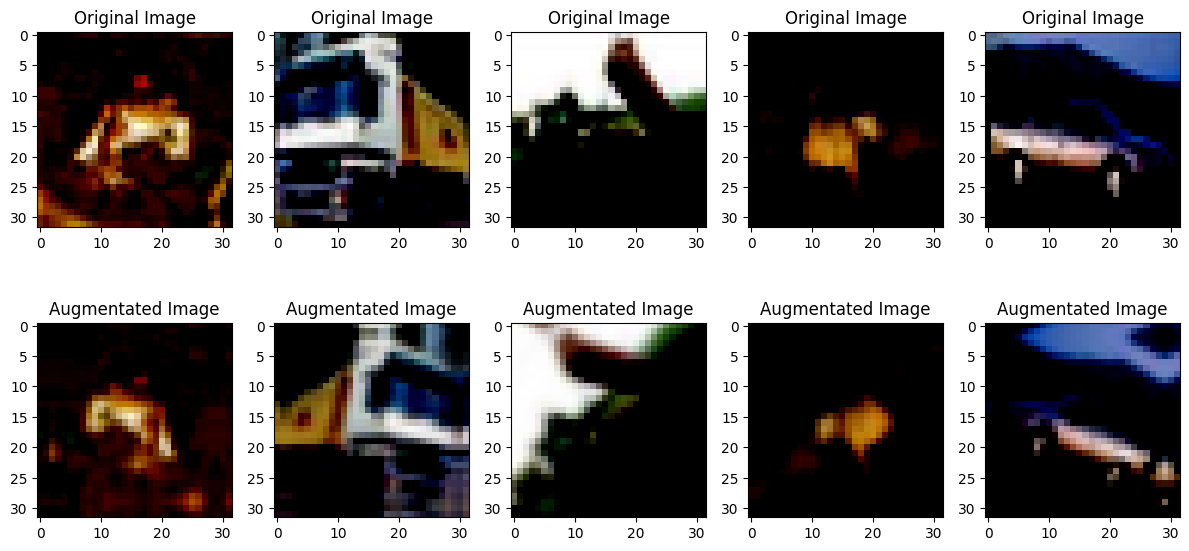

In [ ]:
fig = plt.figure(figsize=(12, 6))

# Plot first 5 images
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_dataAug_combined[i])
    plt.title('Original Image')

# Plot corresponding augmentated 5 images
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_train_dataAug_combined[60000 + i])
    plt.title('Augmentated Image')

plt.tight_layout()
plt.show()

<div class='alert alert-block alert-success'><h4>Final Datasets for GAN Model Improvement</h4></div>

Finally, we are going to convert our finalized datasets to Tensor, from ndarray, for model training.

In [ ]:
# Convert frpm ndarray to Tensor
X_train_dataAug_combined_final = tf.convert_to_tensor((X_train_dataAug_combined))

<hr>
<font size = 5>Model Evaluation</font>
<hr>

Generate images

<hr>
<font size = 5>Conclusion</font>
<hr>